# Data Warehouse usando Python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones varias a utilizar

## Funcion para generar archivo .SQL a partir de un .CSV

In [40]:
import csv

def csv_a_sql(nombre_archivo_csv, nombre_archivo_sql, nombre_tabla):
    """
    Convierte un archivo CSV a un script SQL para crear una tabla e insertar datos.

    Args:
        nombre_archivo_csv: La ruta al archivo CSV de entrada.
        nombre_archivo_sql: La ruta al archivo SQL de salida.
        nombre_tabla: El nombre de la tabla SQL que se creará.
    """

    with open(nombre_archivo_csv, 'r', encoding='utf-8') as archivo_csv, open(nombre_archivo_sql, 'w', encoding='utf-8') as archivo_sql:
        lector_csv = csv.reader(archivo_csv)
        
        # Obtener la primera fila para los nombres de las columnas
        encabezado = next(lector_csv)

        # Crear la sentencia CREATE TABLE
        archivo_sql.write(f"CREATE TABLE {nombre_tabla} (\n")
        for nombre_columna in encabezado:
            # Limpiar y formatear el nombre de la columna para SQL
            nombre_columna = nombre_columna.replace(" ", "_").lower()  # Ejemplo: "Nombre Cliente" -> "nombre_cliente"
            archivo_sql.write(f"    {nombre_columna} TEXT,\n")  # Asume tipo TEXT, puedes ajustarlo
        archivo_sql.write(");\n\n")

        # Crear las sentencias INSERT INTO
        for fila in lector_csv:
            archivo_sql.write(f"INSERT INTO {nombre_tabla} (")
            archivo_sql.write(", ".join(f'{col.replace(" ", "_").lower()}' for col in encabezado))  # Columnas
            archivo_sql.write(") VALUES (")
            archivo_sql.write(", ".join(
                f"'{valor}'" if not valor.replace('.', '', 1).isdigit() else valor  # Verifica si es número
                for valor in fila
            ))
            archivo_sql.write(");\n")

# SISMOS

Cargar Dataset original de Sismos

In [98]:
archivo = "raw_data\\SSNMX_catalogo_19000101_20250213.csv"
data_sismos = pd.read_csv(archivo)
data_sismos.head()

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\4089433804.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sismos = pd.read_csv(archivo)


,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1900-01-20,00:33:30,7.4,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado
1,1900-05-16,14:12:00,6.9,20.00,-105.00,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado
2,1901-03-05,04:45:00,6.9,25.00,-110.00,33.0,"100 km al NORESTE de LA PAZ, BCS",1901-03-05,10:45:00,revisado
3,1901-12-08,20:17:00,7.0,26.00,-110.00,33.0,"83 km al OESTE de AHOME, SIN",1901-12-09,02:17:00,revisado
4,1902-01-16,17:19:00,7.0,17.62,-99.72,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902-01-16,23:19:00,revisado


In [99]:
data_sismos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332391 entries, 0 to 332390
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Fecha                       332391 non-null  object 
 1   Hora                        332391 non-null  object 
 2   Magnitud                    332391 non-null  object 
 3   Latitud                     332391 non-null  float64
 4   Longitud                    332391 non-null  float64
 5   Profundidad                 332391 non-null  float64
 6   Referencia de localizacion  332391 non-null  object 
 7   Fecha UTC                   332391 non-null  object 
 8   Hora UTC                    332391 non-null  object 
 9   Estatus                     332391 non-null  object 
dtypes: float64(3), object(7)
memory usage: 25.4+ MB


In [100]:
data_sismos.describe()

,Latitud,Longitud,Profundidad
count,332391.000000,332391.00000,332391.000000
mean,18.033864,-99.37387,32.030894
std,4.229140,5.99640,36.170389
min,10.271000,-120.59500,0.000000
25%,15.931300,-101.76400,10.000000
50%,16.567300,-98.08920,16.100000
75%,18.154700,-94.91020,37.300000
max,38.092300,-85.54670,338.000000


Como podemos comprobar, las unicas columnas que se cargan como tipos de datos flotantes son las de Latitud, Longitud y Profundidad.
Por lo que podemos concluir que algunas otras como Magnitud que debería ser un valor numerico, puede contar con valores atipicos o que no pertenenezcan al mismo tipo de dato.

In [101]:
data_sismos.shape

(332391, 10)

In [102]:
data_sismos.columns

Index(['Fecha', 'Hora', 'Magnitud', 'Latitud', 'Longitud', 'Profundidad',
       'Referencia de localizacion', 'Fecha UTC', 'Hora UTC', 'Estatus'],
      dtype='object')

Verificar valores nulos

In [103]:
# valores nulos por columna
for columna in data_sismos.columns:
    print(f"{columna}: {data_sismos[columna].isnull().sum()}")


Fecha: 0
Hora: 0
Magnitud: 0
Latitud: 0
Longitud: 0
Profundidad: 0
Referencia de localizacion: 0
Fecha UTC: 0
Hora UTC: 0
Estatus: 0


Podríamos pensar que los datos para este punto están limpios, sin embargo analizando el archivo .CSV, podemos notar que los valores "nulos", están delimitados de forma diferente

In [104]:
data_sismos_clean = data_sismos.copy()

In [105]:
# Definir los valores que representan nulos
null_values = ["NA", "None", "-", "", "null", "no calculable"]

# Reemplazar esos valores con NaN
data_sismos_clean.replace(null_values, np.nan, inplace=True)

data_sismos_clean

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1900-01-20,00:33:30,7.4,20.000,-105.000,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado
1,1900-05-16,14:12:00,6.9,20.000,-105.000,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado
2,1901-03-05,04:45:00,6.9,25.000,-110.000,33.0,"100 km al NORESTE de LA PAZ, BCS",1901-03-05,10:45:00,revisado
3,1901-12-08,20:17:00,7.0,26.000,-110.000,33.0,"83 km al OESTE de AHOME, SIN",1901-12-09,02:17:00,revisado
4,1902-01-16,17:19:00,7.0,17.620,-99.720,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902-01-16,23:19:00,revisado
...,...,...,...,...,...,...,...,...,...,...
332386,2025-02-13,04:45:07,3.3,16.410,-98.442,35.0,"30 km al SUR de OMETEPEC, GRO",2025-02-13,10:45:07,verificado
332387,2025-02-13,04:54:04,3.5,17.657,-95.412,38.3,"37 km al SUR de J RODRIGUEZ CLARA, VER",2025-02-13,10:54:04,verificado
332388,2025-02-13,08:25:52,4.0,14.816,-98.058,16.0,"148 km al SUROESTE de RIO GRANDE, OAX",2025-02-13,14:25:52,verificado
332389,2025-02-13,08:42:33,4.0,15.782,-96.221,37.2,"9 km al OESTE de CRUCECITA, OAX",2025-02-13,14:42:33,verificado


Una vez remplazados, volvemos a buscar los valores nulos

In [106]:
# valores nulos por columna
for columna in data_sismos_clean.columns:
    print(f"{columna}: {data_sismos_clean[columna].isna().sum()}")

Fecha: 0
Hora: 0
Magnitud: 17649
Latitud: 0
Longitud: 0
Profundidad: 0
Referencia de localizacion: 0
Fecha UTC: 0
Hora UTC: 0
Estatus: 0


Eliminamos los valores nulos

In [107]:
# Eliminar filas con valores nulos
data_sismos_clean.dropna(inplace=True)

# Reiniciar los índices después de eliminar filas
data_sismos_clean.reset_index(drop=True, inplace=True)

data_sismos_clean

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1900-01-20,00:33:30,7.4,20.000,-105.000,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado
1,1900-05-16,14:12:00,6.9,20.000,-105.000,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado
2,1901-03-05,04:45:00,6.9,25.000,-110.000,33.0,"100 km al NORESTE de LA PAZ, BCS",1901-03-05,10:45:00,revisado
3,1901-12-08,20:17:00,7.0,26.000,-110.000,33.0,"83 km al OESTE de AHOME, SIN",1901-12-09,02:17:00,revisado
4,1902-01-16,17:19:00,7.0,17.620,-99.720,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902-01-16,23:19:00,revisado
...,...,...,...,...,...,...,...,...,...,...
314737,2025-02-13,04:45:07,3.3,16.410,-98.442,35.0,"30 km al SUR de OMETEPEC, GRO",2025-02-13,10:45:07,verificado
314738,2025-02-13,04:54:04,3.5,17.657,-95.412,38.3,"37 km al SUR de J RODRIGUEZ CLARA, VER",2025-02-13,10:54:04,verificado
314739,2025-02-13,08:25:52,4.0,14.816,-98.058,16.0,"148 km al SUROESTE de RIO GRANDE, OAX",2025-02-13,14:25:52,verificado
314740,2025-02-13,08:42:33,4.0,15.782,-96.221,37.2,"9 km al OESTE de CRUCECITA, OAX",2025-02-13,14:42:33,verificado


In [108]:
# valores nulos por columna
for columna in data_sismos_clean.columns:
    print(f"{columna}: {data_sismos_clean[columna].isna().sum()}")

Fecha: 0
Hora: 0
Magnitud: 0
Latitud: 0
Longitud: 0
Profundidad: 0
Referencia de localizacion: 0
Fecha UTC: 0
Hora UTC: 0
Estatus: 0


Convertimos la columna Magnitud a Float

In [110]:
# convertir la columna magnitud a float
data_sismos_clean["Magnitud"] = data_sismos_clean["Magnitud"].astype(float)

Una vez que el dataset está completamente limpio y que se mantienen las columnas necesarias, podemos decir que está listo

In [111]:
sismos = data_sismos_clean.copy()

### SISMOS LISTO

# POBLACIÓN

Cargar Dataset original de Población

In [4]:
archivo = "raw_data\\conjunto_de_datos_iter_00CSV20.csv"
data_poblacion = pd.read_csv(archivo)
data_poblacion

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\3075714897.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_poblacion = pd.read_csv(archivo)


,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,...,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,TAMLOC
0,0,Total nacional,0,Total nacional,0,Total nacional,NaN,NaN,NaN,126014024,...,30775898,18307193,15211306,6616141,4047100,1788552,3170894,15108204,852871,*
1,0,Total nacional,0,Total nacional,9998,Localidades de una vivienda,NaN,NaN,NaN,250354,...,47005,8385,18981,1732,1113,12775,14143,51293,7154,*
2,0,Total nacional,0,Total nacional,9999,Localidades de dos viviendas,NaN,NaN,NaN,147125,...,25581,5027,11306,971,708,8247,10065,29741,5283,*
3,1,Aguascalientes,0,Total de la entidad Aguascalientes,0,Total de la Entidad,NaN,NaN,NaN,1425607,...,359895,236003,174089,98724,70126,6021,15323,128996,1711,*
4,1,Aguascalientes,0,Total de la entidad Aguascalientes,9998,Localidades de una vivienda,NaN,NaN,NaN,3697,...,732,205,212,48,41,39,62,530,20,*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195657,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,"103°24'52.925"" W","21°33'12.375"" N",1944.0,165,...,24,9,13,0,0,3,9,38,1,1
195658,32,Zacatecas,58,Santa María de la Paz,39,San Isidro,"103°20'14.164"" W","21°29'11.130"" N",2031.0,1,...,*,*,*,*,*,*,*,*,*,1
195659,32,Zacatecas,58,Santa María de la Paz,41,San Miguel Tepetitlán,"103°20'09.356"" W","21°30'15.168"" N",1977.0,97,...,21,12,21,1,1,1,10,19,0,1
195660,32,Zacatecas,58,Santa María de la Paz,42,San Rafael,"103°22'20.134"" W","21°31'39.341"" N",2042.0,3,...,*,*,*,*,*,*,*,*,*,1


In [5]:
data_poblacion.shape

(195662, 286)

In [6]:
data_poblacion.describe()

,ENTIDAD,MUN,LOC,POBTOT,VIVTOT,TVIVHAB
count,195662.000000,195662.000000,195662.000000,1.956620e+05,1.956620e+05,1.956620e+05
mean,16.806743,59.699400,623.572221,2.582252e+03,9.000329e+02,7.218171e+02
std,8.940159,81.370934,1502.609425,2.931486e+05,1.019782e+05,8.195072e+04
min,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000,12.000000,45.000000,4.000000e+00,2.000000e+00,1.000000e+00
50%,16.000000,33.000000,162.000000,1.600000e+01,7.000000e+00,4.000000e+00
75%,25.000000,73.000000,531.000000,1.470000e+02,5.400000e+01,3.800000e+01
max,32.000000,570.000000,9999.000000,1.260140e+08,4.390344e+07,3.523346e+07


In [7]:
data_poblacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195662 entries, 0 to 195661
Columns: 286 entries, ENTIDAD to TAMLOC
dtypes: int64(6), object(280)
memory usage: 426.9+ MB


In [8]:
data_poblacion.columns

Index(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'LONGITUD',
       'LATITUD', 'ALTITUD', 'POBTOT',
       ...
       'VPH_CEL', 'VPH_INTER', 'VPH_STVP', 'VPH_SPMVPI', 'VPH_CVJ',
       'VPH_SINRTV', 'VPH_SINLTC', 'VPH_SINCINT', 'VPH_SINTIC', 'TAMLOC'],
      dtype='object', length=286)

Verificar el filtrado de las columnas de intenteres del dataset original de sismos

In [9]:
data_poblacion.columns[:12]

Index(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'LONGITUD',
       'LATITUD', 'ALTITUD', 'POBTOT', 'POBFEM', 'POBMAS'],
      dtype='object')

Generemos la copia del dataset filtrado

In [10]:
data_poblacion_sliced = data_poblacion.iloc[:, :12]

Verificar valores nulos en el dataset de poblacion

In [11]:
for column in data_poblacion_sliced.columns:
    print(data_poblacion_sliced[column].isna().sum(), "\t", column)

0 	 ENTIDAD
0 	 NOM_ENT
0 	 MUN
0 	 NOM_MUN
0 	 LOC
0 	 NOM_LOC
6230 	 LONGITUD
6230 	 LATITUD
6230 	 ALTITUD
0 	 POBTOT
0 	 POBFEM
0 	 POBMAS


In [12]:
null_counts = data_poblacion_sliced.apply(lambda col: (col == '*').sum())

print("Valores nulos por columna:")
print(null_counts)

Valores nulos por columna:
ENTIDAD         0
NOM_ENT         0
MUN             0
NOM_MUN         0
LOC             0
NOM_LOC         0
LONGITUD        0
LATITUD         0
ALTITUD         0
POBTOT          0
POBFEM      82011
POBMAS      82011
dtype: int64


In [13]:
# Reemplazar '*' con NaN
data_withNull = data_poblacion_sliced.replace('*', pd.NA)

In [14]:
for column in data_withNull.columns:
    print(data_withNull[column].isna().sum(), "\t", column)

0 	 ENTIDAD
0 	 NOM_ENT
0 	 MUN
0 	 NOM_MUN
0 	 LOC
0 	 NOM_LOC
6230 	 LONGITUD
6230 	 LATITUD
6230 	 ALTITUD
0 	 POBTOT
82011 	 POBFEM
82011 	 POBMAS


In [15]:
data_poblacion_sliced_clean = data_withNull.copy()

In [16]:
# Eliminar filas con valores nulos
data_poblacion_sliced_clean.dropna(inplace=True)

# Reiniciar los índices después de eliminar filas
data_poblacion_sliced_clean.reset_index(drop=True, inplace=True)

data_poblacion_sliced_clean.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,POBFEM,POBMAS
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,"102°17'45.768"" W","21°52'47.362"" N",1878.0,863893,444725,419168
1,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,"102°21'25.639"" W","21°53'01.522"" N",1861.0,41,17,24
2,1,Aguascalientes,1,Aguascalientes,106,Arellano,"102°16'26.238"" W","21°48'06.384"" N",1892.0,1169,556,613
3,1,Aguascalientes,1,Aguascalientes,112,Bajío los Vázquez,"102°07'29.341"" W","21°44'50.978"" N",1971.0,41,21,20
4,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Peñuelas,"102°17'35.503"" W","21°43'08.930"" N",1871.0,1054,512,542


In [17]:
null_counts = data_poblacion_sliced_clean.isna().sum()

print("Valores nulos por columna:")
print(null_counts)

Valores nulos por columna:
ENTIDAD     0
NOM_ENT     0
MUN         0
NOM_MUN     0
LOC         0
NOM_LOC     0
LONGITUD    0
LATITUD     0
ALTITUD     0
POBTOT      0
POBFEM      0
POBMAS      0
dtype: int64


In [18]:
data_poblacion_sliced_clean.shape

(108327, 12)

## Conversion de latitud y longitud a valores decimales

In [30]:
data_poblacion_sliced_clean_decimal = data_poblacion_sliced_clean.copy()

In [31]:
import re

# Función para convertir grados, minutos y segundos a decimal
def convertir_a_decimal(valor):
    # Eliminar espacios adicionales al inicio o al final
    valor = valor.strip()
    
    # Usar una expresión regular para extraer grados, minutos, segundos y dirección
    match = re.match(r"(\d+)°(\d+)'(\d+(?:\.\d+)?)\"?\s*([NSEW])", valor)
    if not match:
        raise ValueError(f"Formato inválido: {valor}")
    
    grados = float(match.group(1))
    minutos = float(match.group(2))
    segundos = float(match.group(3))
    direccion = match.group(4)
    
    # Convertir a decimal
    decimal = grados + (minutos / 60) + (segundos / 3600)
    
    # Si es sur (S) o oeste (W), el valor debe ser negativo
    if direccion in ["S", "W"]:
        decimal *= -1
    
    return decimal

In [32]:
# Aplicar la conversión a las columnas LATITUD y LONGITUD
data_poblacion_sliced_clean_decimal["LATITUD"] = data_poblacion_sliced_clean_decimal["LATITUD"].apply(convertir_a_decimal)
data_poblacion_sliced_clean_decimal["LONGITUD"] = data_poblacion_sliced_clean_decimal["LONGITUD"].apply(convertir_a_decimal)

data_poblacion_sliced_clean_decimal

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,ALTITUD,POBTOT,POBFEM,POBMAS
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,-102.296047,21.879823,1878.0,863893,444725,419168
1,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,-102.357122,21.883756,1861.0,41,17,24
2,1,Aguascalientes,1,Aguascalientes,106,Arellano,-102.273955,21.801773,1892.0,1169,556,613
3,1,Aguascalientes,1,Aguascalientes,112,Bajío los Vázquez,-102.124817,21.747494,1971.0,41,21,20
4,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Peñuelas,-102.293195,21.719147,1871.0,1054,512,542
...,...,...,...,...,...,...,...,...,...,...,...,...
108322,32,Zacatecas,58,Santa María de la Paz,30,Las Tablas,-103.261570,21.460688,2464.0,34,20,14
108323,32,Zacatecas,58,Santa María de la Paz,33,Los Horcones,-103.267078,21.498636,2152.0,12,4,8
108324,32,Zacatecas,58,Santa María de la Paz,35,Los Trigos (Mesa de los Trigos),-103.241053,21.497599,2499.0,89,43,46
108325,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,-103.414701,21.553438,1944.0,165,88,77


In [33]:
data_poblacion_sliced_clean_decimal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108327 entries, 0 to 108326
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ENTIDAD   108327 non-null  int64  
 1   NOM_ENT   108327 non-null  object 
 2   MUN       108327 non-null  int64  
 3   NOM_MUN   108327 non-null  object 
 4   LOC       108327 non-null  int64  
 5   NOM_LOC   108327 non-null  object 
 6   LONGITUD  108327 non-null  float64
 7   LATITUD   108327 non-null  float64
 8   ALTITUD   108327 non-null  object 
 9   POBTOT    108327 non-null  int64  
 10  POBFEM    108327 non-null  object 
 11  POBMAS    108327 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 9.9+ MB


Vemos que la columna altitud está definida como object, por lo que procedemos a eliminar la columna, ya que puede traer problemas y tras analizar se llega a la conclusión de que no aporta realemente un valor agregado

In [34]:
# Eliminar columna altitud
data_poblacion_sliced_clean_decimal.drop(columns=["ALTITUD"], inplace=True)
data_poblacion_sliced_clean_decimal

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,POBTOT,POBFEM,POBMAS
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,-102.296047,21.879823,863893,444725,419168
1,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,-102.357122,21.883756,41,17,24
2,1,Aguascalientes,1,Aguascalientes,106,Arellano,-102.273955,21.801773,1169,556,613
3,1,Aguascalientes,1,Aguascalientes,112,Bajío los Vázquez,-102.124817,21.747494,41,21,20
4,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Peñuelas,-102.293195,21.719147,1054,512,542
...,...,...,...,...,...,...,...,...,...,...,...
108322,32,Zacatecas,58,Santa María de la Paz,30,Las Tablas,-103.261570,21.460688,34,20,14
108323,32,Zacatecas,58,Santa María de la Paz,33,Los Horcones,-103.267078,21.498636,12,4,8
108324,32,Zacatecas,58,Santa María de la Paz,35,Los Trigos (Mesa de los Trigos),-103.241053,21.497599,89,43,46
108325,32,Zacatecas,58,Santa María de la Paz,37,Mesa Grande,-103.414701,21.553438,165,88,77


### Limpiar acentos en las columnas que contengan texto
Esto con el fin de normalizar los datos

In [35]:
# Importar la biblioteca necesaria para normalizar texto
import unicodedata

# Función para quitar acentos
def quitar_acentos(texto):
    if isinstance(texto, str):  # Verificar que el valor sea una cadena de texto
        # Normalizar el texto (convertir caracteres acentuados)
        texto_sin_acentos = ''.join(
            c for c in unicodedata.normalize('NFD', texto)
            if unicodedata.category(c) != 'Mn'
        )
        return texto_sin_acentos
    return texto  # Devolver el valor original si no es texto

# Crear una copia del DataFrame original
poblacion_utf8 = data_poblacion_sliced_clean_decimal.copy()

# Identificar columnas de texto (object o string)
columnas_texto = poblacion_utf8.select_dtypes(include=['object']).columns

# Aplicar la función a cada columna de texto
for columna in columnas_texto:
    poblacion_utf8[columna] = poblacion_utf8[columna].apply(quitar_acentos)

# Verificar algunos ejemplos para confirmar que se quitaron los acentos
poblacion_utf8[columnas_texto].head()

,NOM_ENT,NOM_MUN,NOM_LOC,POBFEM,POBMAS
0,Aguascalientes,Aguascalientes,Aguascalientes,444725,419168
1,Aguascalientes,Aguascalientes,Agua Azul,17,24
2,Aguascalientes,Aguascalientes,Arellano,556,613
3,Aguascalientes,Aguascalientes,Bajio los Vazquez,21,20
4,Aguascalientes,Aguascalientes,Buenavista de Penuelas,512,542


Tras limpiar acentos, procedemos a limpiar de comillas simples a los valores de texto, pues esto puede afectar la exportacion a la base de datos

In [36]:
# Identificar columnas de texto (object o string)
columnas_texto = poblacion_utf8.select_dtypes(include=['object']).columns

# Reemplazar comillas simples en las columnas de texto
for columna in columnas_texto:
    poblacion_utf8[columna] = poblacion_utf8[columna].str.replace("'", "", regex=False)

# Verificar los cambios
poblacion_utf8.head()

,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,LONGITUD,LATITUD,POBTOT,POBFEM,POBMAS
0,1,Aguascalientes,1,Aguascalientes,1,Aguascalientes,-102.296047,21.879823,863893,444725,419168
1,1,Aguascalientes,1,Aguascalientes,96,Agua Azul,-102.357122,21.883756,41,17,24
2,1,Aguascalientes,1,Aguascalientes,106,Arellano,-102.273955,21.801773,1169,556,613
3,1,Aguascalientes,1,Aguascalientes,112,Bajio los Vazquez,-102.124817,21.747494,41,21,20
4,1,Aguascalientes,1,Aguascalientes,120,Buenavista de Penuelas,-102.293195,21.719147,1054,512,542


In [138]:
poblacion = poblacion_utf8.copy()

In [139]:
poblacion.shape

(108327, 11)

### POBLACIÓN LISTO

# ECONOMIA

Leer Dataset original economia

In [55]:
data_economia = pd.read_csv("raw_data\\economia_normalizada.csv")
data_economia.head()

,entidad,nombre_entidad,municipio,nombre_municipio,codigo,descripcion_actividad,clasificacion,produccion_bruta_total,insumos_utilizados,consumo_intermedio,valor_agregado,formacion_capital,activos_fijos_adquiridos
0,1,NaN,,NaN,1152,Servicios relacionados con la cra y explotacin...,Rama,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,,NaN,1152,Servicios relacionados con la cra y explotacin...,Rama,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,,NaN,624231,Servicios de emergencia comunitarios prestados...,Clase,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Aguascalientes,001,Aguascalientes,3253,"Fabricacin de fertilizantes, pesticidas y otro...",Rama,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,,NaN,6243,Servicios de capacitacin para el trabajo para ...,Rama,NaN,NaN,NaN,-2.033,0.0,375.0


In [56]:
data_economia.describe()

,entidad,produccion_bruta_total,insumos_utilizados,consumo_intermedio,valor_agregado,formacion_capital,activos_fijos_adquiridos
count,1.805368e+06,8.470700e+05,8.470700e+05,8.470700e+05,1.277084e+06,1.277084e+06,1.277084e+06
mean,1.808536e+01,5.219418e+02,5.709560e+02,7.973581e+02,4.854818e+01,1.818187e+02,1.642086e+02
std,7.939655e+00,1.099325e+04,1.419730e+04,1.807074e+04,7.380273e+01,1.660482e+02,2.514614e+02
min,1.000000e+00,-6.640002e+03,-2.613200e+01,0.000000e+00,-5.558710e+02,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.270000e+00,1.027000e+00,1.844000e+00,2.070400e+01,1.154930e+02,0.000000e+00
50%,1.700000e+01,6.210000e+00,5.216000e+00,9.165000e+00,3.580700e+01,1.743780e+02,0.000000e+00
75%,2.400000e+01,4.967400e+01,4.774700e+01,7.942450e+01,5.968700e+01,2.422770e+02,2.811415e+02
max,3.200000e+01,4.280287e+06,6.400326e+06,8.303585e+06,8.466667e+03,5.335391e+04,1.263154e+04


In [57]:
data_economia.shape

(1805368, 13)

In [58]:
data_economia.columns

Index(['entidad', 'nombre_entidad', 'municipio', 'nombre_municipio', 'codigo',
       'descripcion_actividad', 'clasificacion', 'produccion_bruta_total',
       'insumos_utilizados', 'consumo_intermedio', 'valor_agregado',
       'formacion_capital', 'activos_fijos_adquiridos'],
      dtype='object')

In [59]:
data_economia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805368 entries, 0 to 1805367
Data columns (total 13 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   entidad                   int64  
 1   nombre_entidad            object 
 2   municipio                 object 
 3   nombre_municipio          object 
 4   codigo                    object 
 5   descripcion_actividad     object 
 6   clasificacion             object 
 7   produccion_bruta_total    float64
 8   insumos_utilizados        float64
 9   consumo_intermedio        float64
 10  valor_agregado            float64
 11  formacion_capital         float64
 12  activos_fijos_adquiridos  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 179.1+ MB


Contar valores nulos del dataset

In [60]:
# valores nulos
for columna in data_economia.columns:
    print(f"{columna}: {data_economia[columna].isnull().sum()}")

entidad: 0
nombre_entidad: 118049
municipio: 0
nombre_municipio: 118049
codigo: 0
descripcion_actividad: 6809
clasificacion: 6809
produccion_bruta_total: 958298
insumos_utilizados: 958298
consumo_intermedio: 958298
valor_agregado: 528284
formacion_capital: 528284
activos_fijos_adquiridos: 528284


Nos podemos dar cuenta de que existen una gran cantidad de valores nulos en columnas importantes como lo son la produccion bruta total, esto se puede deber a que el dataset contempla informacion no por estados sino por municipio
Al final lo que es necesario para nuestro analisis son los valores por estado, asi que haremos el experimento de borrar los registros con valores nulos

In [61]:
data_economia_clean = data_economia.copy()

In [62]:
# borrar los valores nulos  
data_economia_clean.dropna(inplace=True)
data_economia_clean.shape

(745970, 13)

Tras borrarlos obtenemos un dataset de 745 mil registros

In [63]:
data_economia_clean.head()

,entidad,nombre_entidad,municipio,nombre_municipio,codigo,descripcion_actividad,clasificacion,produccion_bruta_total,insumos_utilizados,consumo_intermedio,valor_agregado,formacion_capital,activos_fijos_adquiridos
8,28,Tamaulipas,032,Reynosa,337120,"Fabricacin de muebles, excepto cocinas integra...",Clase,153.033,73.438,153.225,37.382,348.510,634.058
17,28,Tamaulipas,032,Reynosa,33792,Fabricacin de persianas y cortineros,Subrama,913.806,450.292,913.706,0.668,288.928,724.590
18,28,Tamaulipas,032,Reynosa,33792,Fabricacin de persianas y cortineros,Subrama,913.806,450.292,913.706,0.668,288.928,724.590
19,28,Tamaulipas,032,Reynosa,337920,Fabricacin de persianas y cortineros,Clase,913.806,450.292,913.706,0.668,288.928,724.590
20,28,Tamaulipas,032,Reynosa,337920,Fabricacin de persianas y cortineros,Clase,913.806,450.292,913.706,0.668,288.928,724.590


In [64]:
data_economia_clean.describe()

,entidad,produccion_bruta_total,insumos_utilizados,consumo_intermedio,valor_agregado,formacion_capital,activos_fijos_adquiridos
count,745970.000000,745970.000000,7.459700e+05,7.459700e+05,745970.000000,745970.000000,745970.000000
mean,17.839573,206.327969,2.331823e+02,3.231380e+02,47.181789,185.246481,158.093111
std,7.882226,3165.058729,4.899387e+03,5.595603e+03,66.538265,155.596542,223.731469
min,1.000000,-6640.002000,-2.613200e+01,0.000000e+00,-555.871000,0.000000,0.000000
25%,12.000000,1.072000,8.670000e-01,1.555000e+00,22.455000,129.677000,0.000000
50%,16.000000,4.418000,3.734000e+00,6.576000e+00,36.237000,176.382000,0.000000
75%,24.000000,27.328000,2.680200e+01,4.447800e+01,58.026000,236.607000,271.685500
max,32.000000,475017.229000,1.300367e+06,1.342808e+06,8466.667000,53353.911000,11487.430000


Observamos un dataset el cual es muy trabajable, sin valores nulos y ordenado, en este dataset podemos tener los datos por municipio, pero por fines practicos, buscaremos obtener un dataset que separe unicamente por estado

In [65]:
data_economia_clean["nombre_entidad"].unique()

array(['Tamaulipas', 'Campeche', 'Chihuahua', 'Chiapas', 'Puebla',
       'San Luis Potos', 'Tlaxcala', 'Baja California Sur', 'Colima',
       'Guerrero', 'Ciudad de Mxico', 'Guanajuato', 'Morelos',
       'Zacatecas', 'Jalisco', 'Mxico', 'Aguascalientes', 'Nuevo Len',
       'Oaxaca', 'Coahuila de Zaragoza', 'Michoacn de Ocampo', 'Sonora',
       'Durango', 'Baja California', 'Hidalgo', 'Quertaro de Arteaga',
       'Nayarit', 'Sinaloa', 'Tabasco', 'Quintana Roo',
       'Veracruz de Ignacio de la Llave', 'Yucatn'], dtype=object)

In [66]:
# Seleccionar solo las columnas relacionadas con los estados y las numéricas
columnas_estado = [
    "entidad", 
    "nombre_entidad", 
    "produccion_bruta_total", 
    "insumos_utilizados", 
    "consumo_intermedio", 
    "valor_agregado", 
    "formacion_capital", 
    "activos_fijos_adquiridos"
]

# Filtrar el dataset para mantener solo las columnas seleccionadas
data_economia_clean_estado = data_economia_clean[columnas_estado]

# Agrupar por estado (nombre_entidad) y calcular la media para las columnas numéricas
data_economia_clean_estado = data_economia_clean_estado.groupby("nombre_entidad").mean().reset_index()

# Mostrar el resultado
data_economia_clean_estado

,nombre_entidad,entidad,produccion_bruta_total,insumos_utilizados,consumo_intermedio,valor_agregado,formacion_capital,activos_fijos_adquiridos
0,Aguascalientes,1.0,415.688970,406.180314,565.485103,39.171273,212.967537,207.990443
1,Baja California,2.0,635.289316,619.101969,952.796500,44.332165,283.455966,376.115924
2,Baja California Sur,3.0,212.644686,259.987752,365.475133,40.776352,243.462586,274.606066
3,Campeche,4.0,96.423859,110.162071,163.581780,45.907354,186.207157,167.538823
4,Chiapas,7.0,31.554876,46.001539,62.317679,48.333857,140.981941,90.105823
5,Chihuahua,8.0,263.100868,264.861724,404.821288,42.398126,218.362213,220.233976
6,Ciudad de Mxico,9.0,1316.185878,1848.554282,2456.910854,46.411031,278.451751,357.767460
7,Coahuila de Zaragoza,5.0,518.970620,448.933074,642.162673,45.672469,223.652439,242.864775
8,Colima,6.0,101.932057,140.681912,194.297141,41.299012,212.835520,209.796288
9,Durango,10.0,129.170771,143.939978,202.822768,52.440776,186.527012,146.204069


Con lo anterior, nos quedamos con *2* datasets, uno que cuenta con la informacion total y especifica por municipios y otro que cuenta unicamente con la informacion de los estados

In [67]:
economia_municipios = data_economia_clean.copy()
economia_estados = data_economia_clean_estado.copy()

ECONOMIA LISTO

# Procedimiento para pasarlos a una base de datos

Primero deberán ser convertidos a archivos .CSV de los cuales facilmente se pueden obtener archivos .SQL para que los mismos sean usados en cualquier sistema gestor de bases de datos

Generar archivs .CSV de todos los datasets trabajados: 
* sismos
* poblacion
* economia_municipio
* economia_estados

In [ ]:
sismos.to_csv("raw_data_limpio/sismos.csv", index=False)
poblacion.to_csv("raw_data_limpio/poblacion.csv", index=False)
economia_municipios.to_csv("raw_data_limpio/economia_municipios.csv", index=False)
economia_estados.to_csv("raw_data_limpio/economia_estados.csv", index=False)

# Procedimiento para convertir los archivos .CSV generados a archivos .SQL

In [245]:
for archivo_csv in ["raw_data_limpio/sismos.csv", "raw_data_limpio/poblacion.csv", "raw_data_limpio/economia_municipios.csv", "raw_data_limpio/economia_estados.csv"]:
    archivo_sql = archivo_csv.split('/')[-1].replace(".csv", ".sql")
    nombre_tabla = archivo_csv.split("/")[-1].replace(".csv", "")
    csv_a_sql(archivo_csv, "SQLs/" + archivo_sql, nombre_tabla)

# ANÁLISIS Y VISUALIZACIONES

## Preguntas

In [68]:
sismos.columns

Index(['Fecha', 'Hora', 'Magnitud', 'Latitud', 'Longitud', 'Profundidad',
       'Referencia de localizacion', 'Fecha UTC', 'Hora UTC', 'Estatus'],
      dtype='object')

In [69]:
poblacion.columns

Index(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'LONGITUD',
       'LATITUD', 'POBTOT', 'POBFEM', 'POBMAS'],
      dtype='object')

In [70]:
economia_estados.columns

Index(['nombre_entidad', 'entidad', 'produccion_bruta_total',
       'insumos_utilizados', 'consumo_intermedio', 'valor_agregado',
       'formacion_capital', 'activos_fijos_adquiridos'],
      dtype='object')

In [71]:
economia_municipios.columns

Index(['entidad', 'nombre_entidad', 'municipio', 'nombre_municipio', 'codigo',
       'descripcion_actividad', 'clasificacion', 'produccion_bruta_total',
       'insumos_utilizados', 'consumo_intermedio', 'valor_agregado',
       'formacion_capital', 'activos_fijos_adquiridos'],
      dtype='object')

# Dimensiones y Tablas de Hechos

# Dimensiones

In [76]:
sismos.head(2)

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1900-01-20,00:33:30,7.4,20.0,-105.0,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-01-20,06:33:30,revisado
1,1900-05-16,14:12:00,6.9,20.0,-105.0,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900-05-16,20:12:00,revisado


## Dimensión Tiempo

In [77]:
# Información sobre cuándo ocurrieron los sismos 
# Incluye: año, mes, día, temporada 
# Usa los campos 'fecha' y 'hora' de tu tabla de sismos 

dimTiempo = sismos[["Fecha", "Hora"]].copy()
dimTiempo["Fecha"] = pd.to_datetime(dimTiempo["Fecha"])
dimTiempo["Año"] = dimTiempo["Fecha"].dt.year
dimTiempo["Mes"] = dimTiempo["Fecha"].dt.month
dimTiempo["Día"] = dimTiempo["Fecha"].dt.day
dimTiempo["Temporada"] = dimTiempo["Fecha"].dt.quarter
dimTiempo.drop(columns=["Fecha", "Hora"], inplace=True) 

dimTiempo.head(5)

,Año,Mes,Día,Temporada
0,1900,1,20,1
1,1900,5,16,2
2,1901,3,5,1
3,1901,12,8,4
4,1902,1,16,1


## Dimensión Lugar

In [78]:
# Información sobre dónde ocurrieron los sismos y dónde vive la gente 
# Incluye: estados, municipios, coordenadas 
# Usa ENTIDAD, NOM_ENT, MUN, NOM_MUN de tus datos de población 
# Usa latitud y longitud de tu tabla de sismos

dimLugar = poblacion[["ENTIDAD", "NOM_ENT", "MUN", "NOM_MUN"]].copy()
dimLugar.drop_duplicates(inplace=True)
dimLugar.dropna(inplace=True)
dimLugar.head(5)

,ENTIDAD,NOM_ENT,MUN,NOM_MUN
0,1,Aguascalientes,1,Aguascalientes
281,1,Aguascalientes,2,Asientos
369,1,Aguascalientes,3,Calvillo
473,1,Aguascalientes,4,Cosio
494,1,Aguascalientes,5,Jesus Maria


## Dimensión Sismo

In [79]:
# Información sobre los tipos de sismos 
# Incluye: categorías de magnitud (leve, moderado, fuerte) 
# Usa el campo 'magnitud' y 'profundidad' de tu tabla de sismos 

dimSismos = sismos[["Magnitud", "Profundidad"]].copy()
dimSismos["Categoría"] = pd.cut(dimSismos["Magnitud"], bins=[0, 5, 7, 10], labels=["Leve", "Moderado", "Fuerte"], right=False)
dimSismos.drop(columns=["Magnitud", "Profundidad"], inplace=True)
dimSismos.head(5)

,Categoría
0,Fuerte
1,Moderado
2,Moderado
3,Fuerte
4,Fuerte


## Dimensión Población

In [80]:
# Información sobre cuánta gente vive en cada lugar 
# Incluye: número de habitantes, hombres, mujeres 
# Usa POBTOT, POBMAS, POBFEM de tus datos de población 

dimPoblacion = poblacion[["POBTOT", "POBFEM", "POBMAS"]].copy()
dimPoblacion.head(5)


,POBTOT,POBFEM,POBMAS
0,863893,444725,419168
1,41,17,24
2,1169,556,613
3,41,21,20
4,1054,512,542


## Dimensión Economía

In [81]:
# Información sobre la actividad económica 
# Incluye: producción, consumo 
# Usa 'produccion_bruta_total' y 'a121a' de tus datos económicos

dimEconomia = economia_estados[["produccion_bruta_total", "insumos_utilizados"]].copy()
dimEconomia.head(5)

,produccion_bruta_total,insumos_utilizados
0,415.688970,406.180314
1,635.289316,619.101969
2,212.644686,259.987752
3,96.423859,110.162071
4,31.554876,46.001539


# Hechos

## Hechos de Sismos

In [82]:
# Cuántos sismos ocurren por lugar y tiempo 
# Estadísticas de magnitudes y profundidades 
# Ejemplo: "En Oaxaca ocurrieron 50 sismos de magnitud fuerte en 2023" 

hechosSismos = sismos[["Magnitud", "Profundidad", "Referencia de localizacion", "Fecha"]].copy()
hechosSismos["Fecha"] = pd.to_datetime(hechosSismos["Fecha"])
hechosSismos["Año"] = hechosSismos["Fecha"].dt.year
hechosSismos["Mes"] = hechosSismos["Fecha"].dt.month
hechosSismos["Día"] = hechosSismos["Fecha"].dt.day
hechosSismos["Temporada"] = hechosSismos["Fecha"].dt.quarter
hechosSismos.drop(columns=["Fecha"], inplace=True)
hechosSismos.head(5)

,Magnitud,Profundidad,Referencia de localizacion,Año,Mes,Día,Temporada
0,7.4,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900,1,20,1
1,6.9,33.0,"71 km al NOROESTE de AUTLAN DE NAVARRO, JAL",1900,5,16,2
2,6.9,33.0,"100 km al NORESTE de LA PAZ, BCS",1901,3,5,1
3,7.0,33.0,"83 km al OESTE de AHOME, SIN",1901,12,8,4
4,7.0,33.0,"21 km al OESTE de ZUMPANGO DEL RIO, GRO",1902,1,16,1


## Hechos de Impacto en Población

In [83]:
# Cuánta gente vive en zonas con sismos 
# Relación entre densidad de población y sismos 
# Ejemplo: "Hay 2 millones de personas viviendo en zonas con sismos frecuentes" 

hechosPoblacion = poblacion[["POBTOT", "NOM_ENT", "NOM_MUN"]].copy()
hechosPoblacion.head()

,POBTOT,NOM_ENT,NOM_MUN
0,863893,Aguascalientes,Aguascalientes
1,41,Aguascalientes,Aguascalientes
2,1169,Aguascalientes,Aguascalientes
3,41,Aguascalientes,Aguascalientes
4,1054,Aguascalientes,Aguascalientes


## Hechos de Impacto Económico

In [86]:
# Cuánta producción económica está en zonas de riesgo 
# Identificar "estados parásitos" (mucho consumo, poca producción) 
# Ejemplo: "El estado X tiene alto consumo y baja producción, y además tiene muchos sismos" 

hechosEconomia = economia_estados[["produccion_bruta_total", "insumos_utilizados", "nombre_entidad"]].copy()
hechosEconomia.head(5)

,produccion_bruta_total,insumos_utilizados,nombre_entidad
0,415.688970,406.180314,Aguascalientes
1,635.289316,619.101969,Baja California
2,212.644686,259.987752,Baja California Sur
3,96.423859,110.162071,Campeche
4,31.554876,46.001539,Chiapas


# Análisis y Cálculos de interés

¿En qué estados ocurren más sismos fuertes? 

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\3907890353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\3907890353.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sismos_por_estado.values, y=sismos_por_estado.index, palette="viridis")


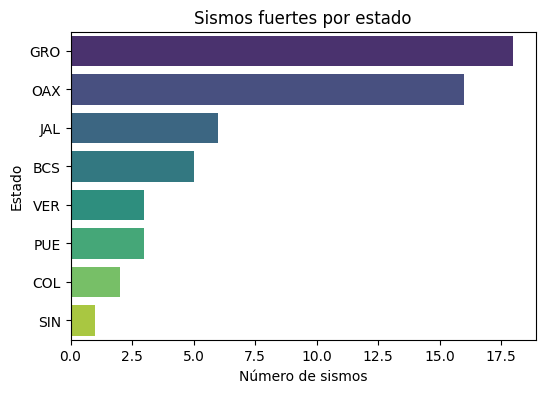

In [112]:
# Filtrar los sismos con magnitud mayor o igual a 7.0
sismos_fuertes = sismos[sismos["Magnitud"] >= 7.0]

# Extraer las siglas del estado desde la columna 'Referencia de localización'
sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')

# Contar los sismos fuertes por estado
sismos_por_estado = sismos_fuertes["Estado"].value_counts()

# Mostrar los estados con más sismos fuertes
sismos_por_estado

# Crear un gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=sismos_por_estado.values, y=sismos_por_estado.index, palette="viridis")
plt.title("Sismos fuertes por estado")
plt.xlabel("Número de sismos")
plt.ylabel("Estado")
plt.show()

Analizar el 

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\1229412973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\1229412973.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sismos_fuertes["Nombre_Estado"] = sismos_fuertes["Estado"].map(mapeo_estados)
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\1229412973.py:61: UserWarning

<Figure size 1400x800 with 0 Axes>

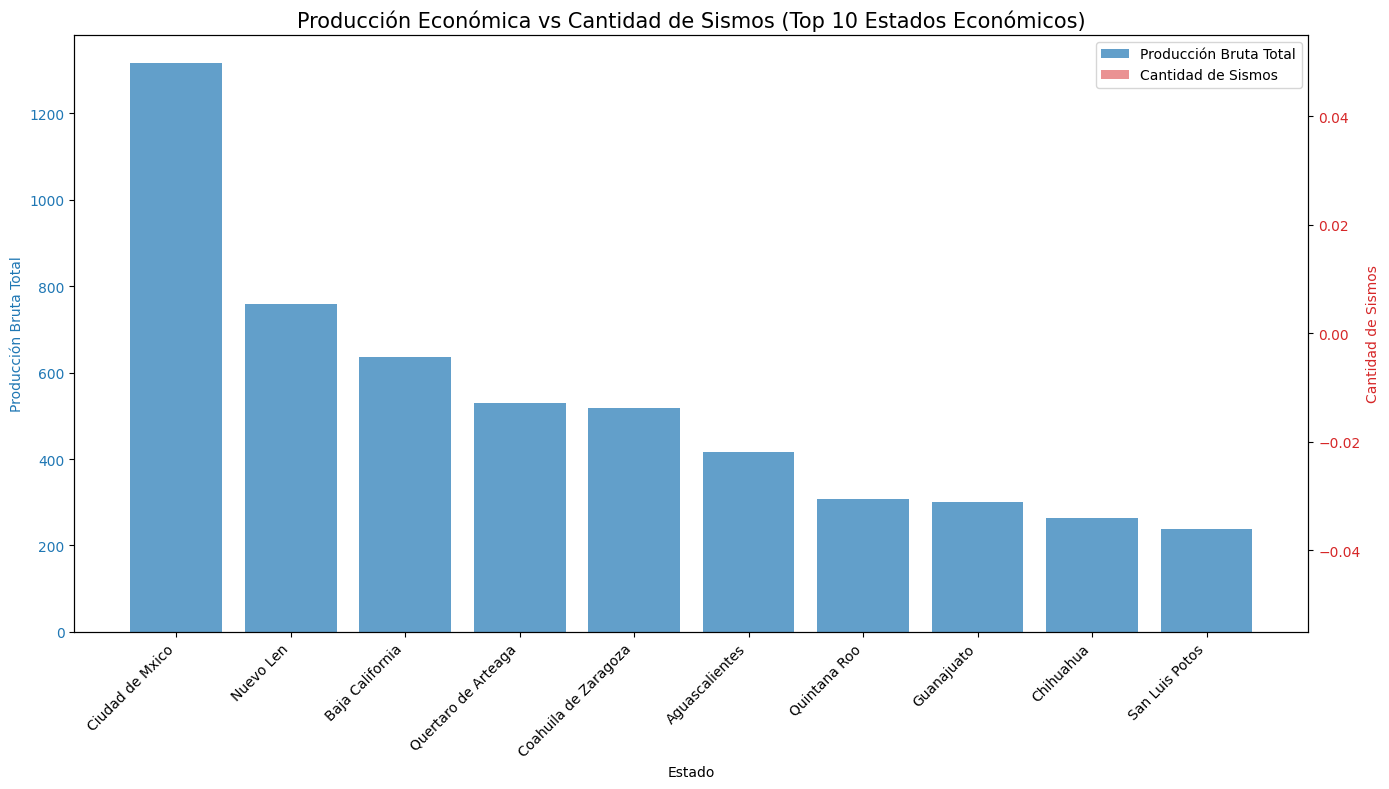

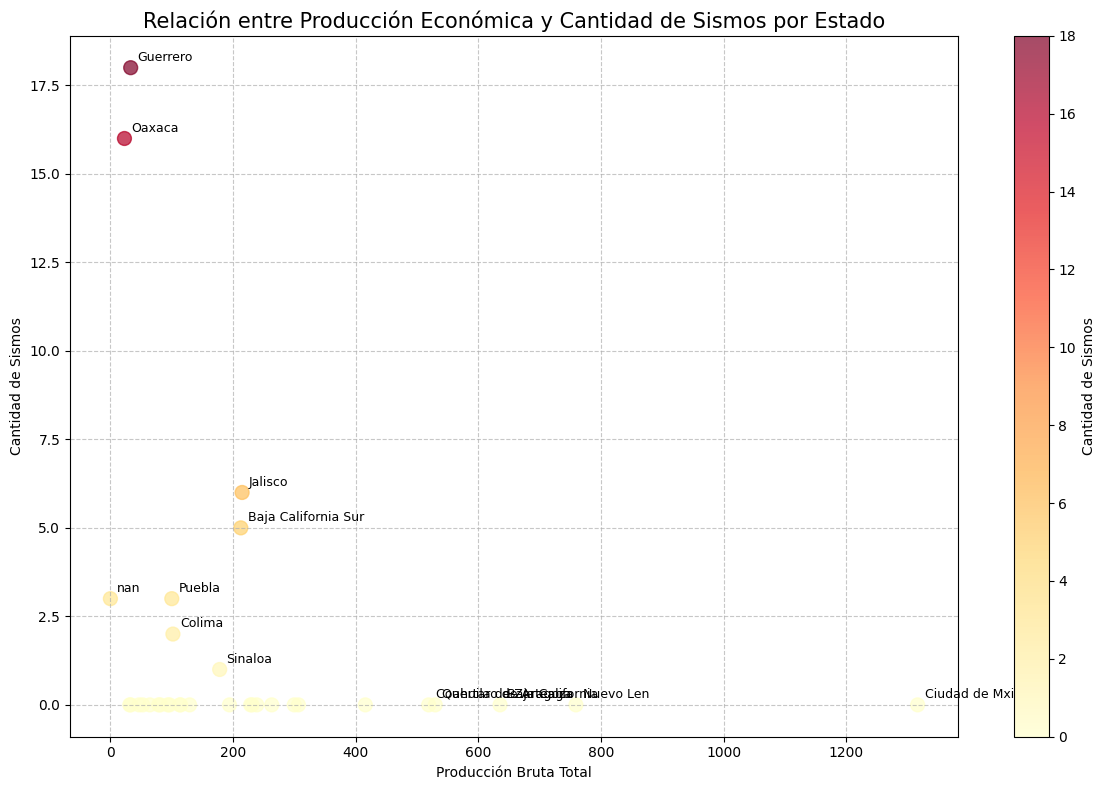

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\1229412973.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


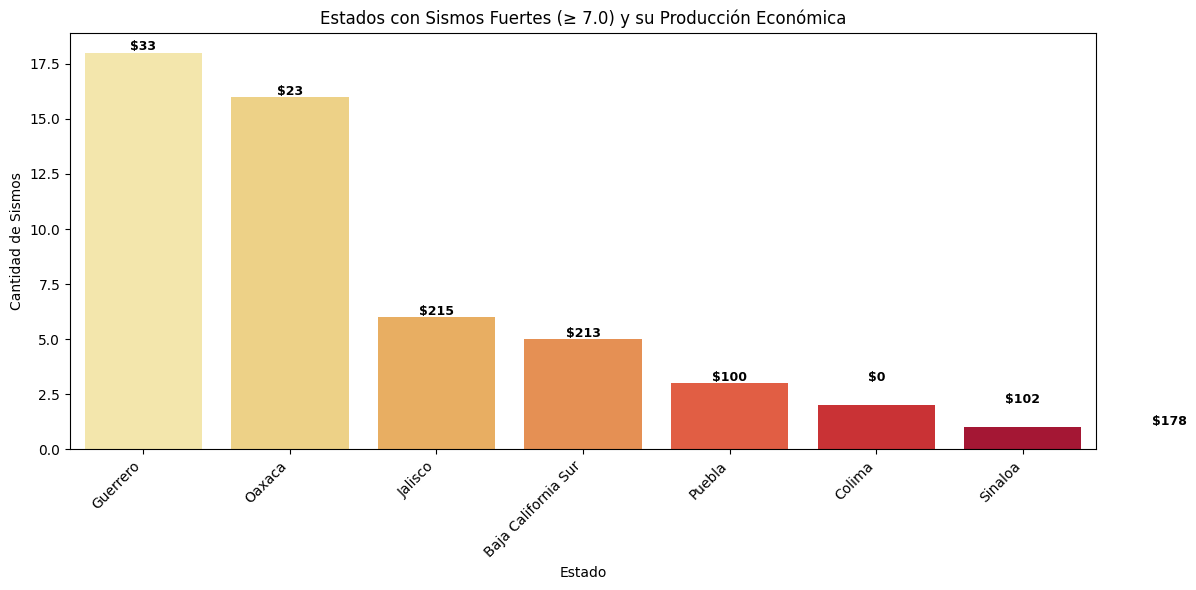

In [114]:
# Filtrar los sismos con magnitud mayor o igual a 7.0
sismos_fuertes = sismos[sismos["Magnitud"] >= 7.0]

# Extraer las siglas del estado desde la columna 'Referencia de localizacion'
sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')

# Crear un diccionario de mapeo entre siglas y nombres completos
mapeo_estados = {
    'AGS': 'Aguascalientes', 'BC': 'Baja California', 'BCS': 'Baja California Sur',
    'CAMP': 'Campeche', 'CHIS': 'Chiapas', 'CHIH': 'Chihuahua', 'CDMX': 'Ciudad de México',
    'COAH': 'Coahuila de Zaragoza', 'COL': 'Colima', 'DGO': 'Durango', 'GTO': 'Guanajuato',
    'GRO': 'Guerrero', 'HGO': 'Hidalgo', 'JAL': 'Jalisco', 'MEX': 'México',
    'MICH': 'Michoacán de Ocampo', 'MOR': 'Morelos', 'NAY': 'Nayarit', 'NL': 'Nuevo León',
    'OAX': 'Oaxaca', 'PUE': 'Puebla', 'QRO': 'Querétaro', 'QROO': 'Quintana Roo',
    'SLP': 'San Luis Potosí', 'SIN': 'Sinaloa', 'SON': 'Sonora', 'TAB': 'Tabasco',
    'TAMPS': 'Tamaulipas', 'TLAX': 'Tlaxcala', 'VER': 'Veracruz', 'YUC': 'Yucatán',
    'ZAC': 'Zacatecas'
}

# Mapear las siglas a nombres completos
sismos_fuertes["Nombre_Estado"] = sismos_fuertes["Estado"].map(mapeo_estados)

# Agrupar los sismos por entidad y contar la cantidad de sismos por entidad
sismos_por_entidad = sismos_fuertes.groupby("Nombre_Estado").size().reset_index(name="Cantidad_Sismos")

# Obtener datos económicos por estado
economia_por_estado = economia_estados.groupby("nombre_entidad")["produccion_bruta_total"].sum().reset_index()

# Combinar datos de sismos y economía
sismos_economia = pd.merge(
    sismos_por_entidad, 
    economia_por_estado, 
    left_on="Nombre_Estado", 
    right_on="nombre_entidad", 
    how="outer"
)

# Llenar NaN con ceros 
sismos_economia["Cantidad_Sismos"] = sismos_economia["Cantidad_Sismos"].fillna(0)
sismos_economia["produccion_bruta_total"] = sismos_economia["produccion_bruta_total"].fillna(0)

# Ordenar por producción bruta total
sismos_economia_sorted = sismos_economia.sort_values(by="produccion_bruta_total", ascending=False)

# Calcular correlación entre producción económica y cantidad de sismos
correlacion = sismos_economia["produccion_bruta_total"].corr(sismos_economia["Cantidad_Sismos"])

# Visualización 1: Gráfico de barras comparando producción vs sismos (top 10 estados económicos)
plt.figure(figsize=(14, 8))
top10 = sismos_economia_sorted.head(10).copy()

# Crear un gráfico con dos ejes Y
fig, ax1 = plt.subplots(figsize=(14, 8))

# Eje Y1: Producción bruta total
color1 = 'tab:blue'
ax1.set_xlabel('Estado')
ax1.set_ylabel('Producción Bruta Total', color=color1)
bars1 = ax1.bar(top10["nombre_entidad"], top10["produccion_bruta_total"], color=color1, alpha=0.7, label='Producción Bruta Total')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticklabels(top10["nombre_entidad"], rotation=45, ha='right')

# Crear segundo eje Y
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Cantidad de Sismos', color=color2)
bars2 = ax2.bar(top10["nombre_entidad"], top10["Cantidad_Sismos"], color=color2, alpha=0.5, label='Cantidad de Sismos')
ax2.tick_params(axis='y', labelcolor=color2)

# Título y leyenda
plt.title('Producción Económica vs Cantidad de Sismos (Top 10 Estados Económicos)', fontsize=15)
fig.tight_layout()

# Añadir leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

# Visualización 2: Gráfico de dispersión
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    sismos_economia["produccion_bruta_total"], 
    sismos_economia["Cantidad_Sismos"],
    s=100, 
    c=sismos_economia["Cantidad_Sismos"], 
    cmap="YlOrRd", 
    alpha=0.7
)

# Añadir nombres de los estados importantes
for i, row in sismos_economia.iterrows():
    if row["Cantidad_Sismos"] > 0 or row["produccion_bruta_total"] > 500:
        plt.annotate(
            row["nombre_entidad"], 
            (row["produccion_bruta_total"], row["Cantidad_Sismos"]),
            fontsize=9,
            xytext=(5, 5),
            textcoords='offset points'
        )

plt.colorbar(scatter, label='Cantidad de Sismos')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Relación entre Producción Económica y Cantidad de Sismos por Estado', fontsize=15)
plt.xlabel('Producción Bruta Total')
plt.ylabel('Cantidad de Sismos')
plt.tight_layout()
plt.show()

# Visualización 3: Mapa de calor para estados con sismos
estados_con_sismos = sismos_economia[sismos_economia["Cantidad_Sismos"] > 0].sort_values(by="Cantidad_Sismos", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="nombre_entidad", 
    y="Cantidad_Sismos", 
    data=estados_con_sismos,
    palette="YlOrRd"
)
plt.title('Estados con Sismos Fuertes (≥ 7.0) y su Producción Económica')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Sismos')
plt.xticks(rotation=45, ha='right')

# Añadir texto con valor de producción económica
for i, row in enumerate(estados_con_sismos.itertuples()):
    plt.text(
        i, 
        row.Cantidad_Sismos + 0.1, 
        f'${row.produccion_bruta_total:.0f}', 
        ha='center',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

Índice de Riesgo Sismico

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2511090974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2511090974.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sismos_fuertes["Nombre_Estado"] = sismos_fuertes["Estado"].map(mapeo_estados)
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2511090974.py:72: FutureWarni

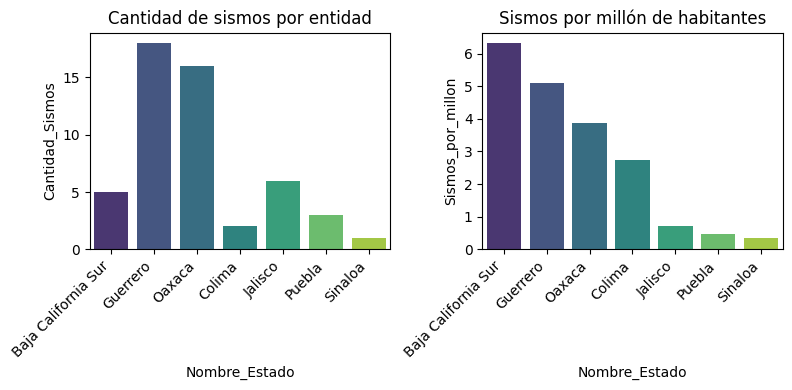

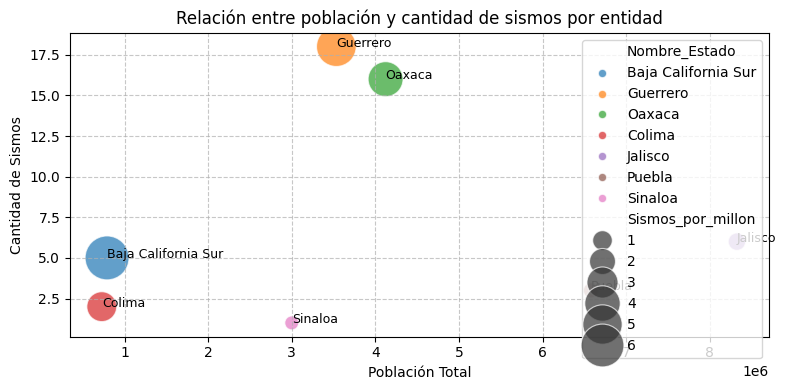

In [115]:
# Filtrar los sismos con magnitud mayor o igual a 7.0
sismos_fuertes = sismos[sismos["Magnitud"] >= 7.0]

# Extraer las siglas del estado desde la columna 'Referencia de localizacion'
sismos_fuertes["Estado"] = sismos_fuertes["Referencia de localizacion"].str.extract(r',\s*([A-Z]{3})$')


# Crear un diccionario de mapeo entre siglas y nombres completos
mapeo_estados = {
    'AGS': 'Aguascalientes',
    'BC': 'Baja California',
    'BCS': 'Baja California Sur',
    'CAMP': 'Campeche',
    'CHIS': 'Chiapas',
    'CHIH': 'Chihuahua',
    'CDMX': 'Ciudad de México',
    'COAH': 'Coahuila',
    'COL': 'Colima',
    'DGO': 'Durango',
    'GTO': 'Guanajuato',
    'GRO': 'Guerrero',
    'HGO': 'Hidalgo',
    'JAL': 'Jalisco',
    'MEX': 'México',
    'MICH': 'Michoacán',
    'MOR': 'Morelos',
    'NAY': 'Nayarit',
    'NL': 'Nuevo León',
    'OAX': 'Oaxaca',
    'PUE': 'Puebla',
    'QRO': 'Querétaro',
    'QROO': 'Quintana Roo',
    'SLP': 'San Luis Potosí',
    'SIN': 'Sinaloa',
    'SON': 'Sonora',
    'TAB': 'Tabasco',
    'TAMPS': 'Tamaulipas',
    'TLAX': 'Tlaxcala',
    'VER': 'Veracruz',
    'YUC': 'Yucatán',
    'ZAC': 'Zacatecas'
}

# Mapear las siglas a nombres completos
sismos_fuertes["Nombre_Estado"] = sismos_fuertes["Estado"].map(mapeo_estados)


# Agrupar los sismos por entidad y contar la cantidad de sismos por entidad
sismos_por_entidad = sismos_fuertes.groupby("Nombre_Estado").size().reset_index(name="Cantidad_Sismos")

# Agrupar la población por entidad y sumar la población total por entidad
poblacion_por_entidad = poblacion.groupby("NOM_ENT")["POBTOT"].sum().reset_index()

# Combinar ambos datasets en un solo dataframe
riesgo_sismos = pd.merge(sismos_por_entidad, poblacion_por_entidad, left_on="Nombre_Estado", right_on="NOM_ENT", how="inner")

# Si no hay datos después del merge, usar un enfoque alternativo
if len(riesgo_sismos) == 0:
    print("No se encontraron coincidencias entre los nombres de estados. Intentando un enfoque alternativo.")
    # Podrías implementar un enfoque alternativo aquí
else:
    # Calcular la relación entre cantidad de sismos y población
    riesgo_sismos["Sismos_por_millon"] = (riesgo_sismos["Cantidad_Sismos"] / riesgo_sismos["POBTOT"]) * 1e6

    # Ordenar por la relación de sismos por millón de habitantes
    riesgo_sismos = riesgo_sismos.sort_values(by="Sismos_por_millon", ascending=False)


    # Visualizar con un gráfico de barras (más adecuado para pocos datos)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(data=riesgo_sismos, x="Nombre_Estado", y="Cantidad_Sismos", palette="viridis")
    plt.title("Cantidad de sismos por entidad")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.subplot(1, 2, 2)
    sns.barplot(data=riesgo_sismos, x="Nombre_Estado", y="Sismos_por_millon", palette="viridis")
    plt.title("Sismos por millón de habitantes")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # También mostrar el gráfico de dispersión original con ajustes
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=riesgo_sismos, x="POBTOT", y="Cantidad_Sismos", 
                   size="Sismos_por_millon", hue="Nombre_Estado", 
                   sizes=(100, 1000), alpha=0.7)
    plt.title("Relación entre población y cantidad de sismos por entidad")
    plt.xlabel("Población Total")
    plt.ylabel("Cantidad de Sismos")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Agregar etiquetas a los puntos
    for i, row in riesgo_sismos.iterrows():
        plt.text(row["POBTOT"], row["Cantidad_Sismos"], 
                row["Nombre_Estado"], fontsize=9)
    
    plt.tight_layout()
    plt.show()

Estados parasitos

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2068763143.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=hechosEconomia, x="nombre_entidad", y="Diferencia", palette="coolwarm")


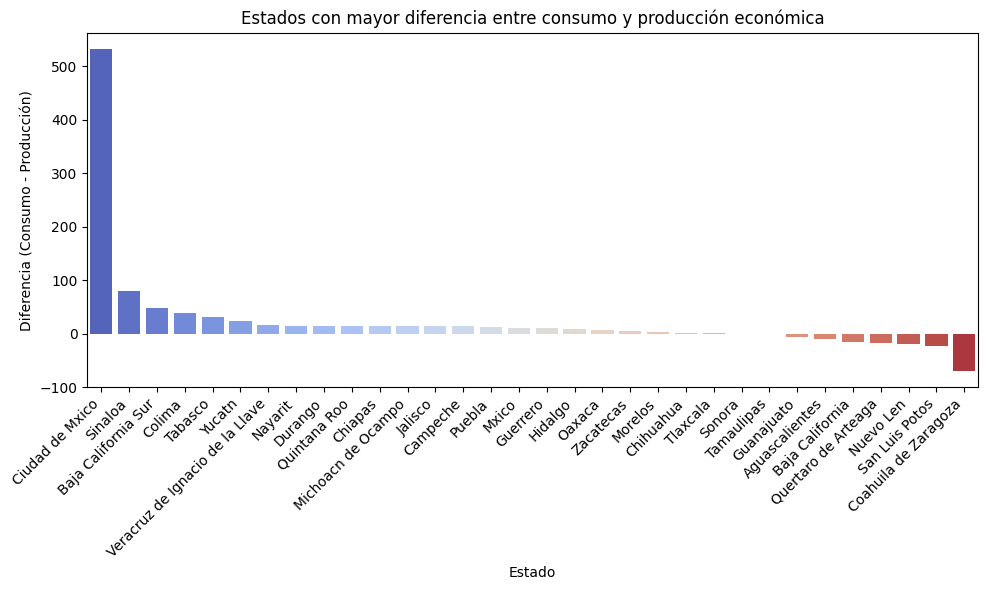

In [116]:
# Identificar "estados parásitos" (mucho consumo, poca producción) 
# Ejemplo: "El estado X tiene alto consumo y baja producción, y además tiene muchos sismos" con grafica
hechosEconomia["Diferencia"] = hechosEconomia["insumos_utilizados"] - hechosEconomia["produccion_bruta_total"]
hechosEconomia = hechosEconomia.sort_values(by="Diferencia", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=hechosEconomia, x="nombre_entidad", y="Diferencia", palette="coolwarm")
plt.title("Estados con mayor diferencia entre consumo y producción económica")
plt.xlabel("Estado")
plt.ylabel("Diferencia (Consumo - Producción)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Impacto economico poblacional

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2769694341.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


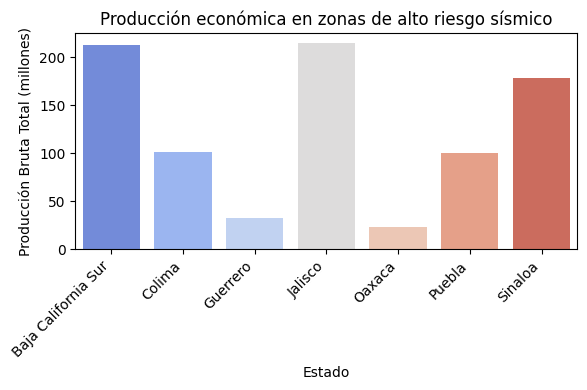

In [121]:
# Realizar el merge de datos
zonas_alto_riesgo = sismos_por_entidad.merge(
    economia_por_estado, 
    left_on="Nombre_Estado", 
    right_on="nombre_entidad", 
    how="inner"
)

# Calcular la producción económica total en zonas de alto riesgo sísmico
produccion_total_riesgo = zonas_alto_riesgo["produccion_bruta_total"].sum()

# Visualización 
plt.figure(figsize=(6, 4))
sns.barplot(
    data=zonas_alto_riesgo, 
    x="Nombre_Estado", 
    y="produccion_bruta_total", 
    palette="coolwarm"
)
plt.title("Producción económica en zonas de alto riesgo sísmico")
plt.xlabel("Estado")
plt.ylabel("Producción Bruta Total (millones)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Comparación por genero

In [123]:
poblacion.columns

Index(['ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'LONGITUD',
       'LATITUD', 'POBTOT', 'POBFEM', 'POBMAS'],
      dtype='object')

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\3545560821.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poblacion_zonas_riesgo["porcentaje_mujeres"] = (poblacion_zonas_riesgo["POBFEM"] / poblacion_zonas_riesgo["POBTOT"]) * 100
C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\3545560821.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poblacion_zonas_riesgo["porcentaje_hombres"] = (poblacion_zonas_riesgo["POBMAS"] / poblacion_zonas_riesgo["POBTOT"]) * 100
C:\Users\Dell Latitude

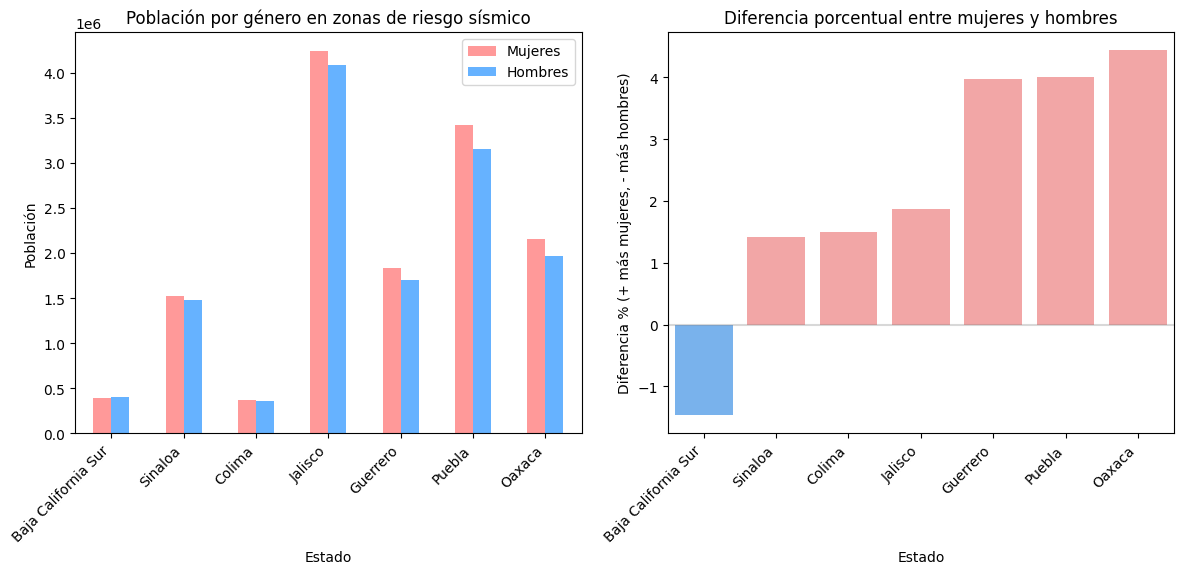

Promedio de diferencia de género en zonas de riesgo: 2.25%
Mayor diferencia a favor de mujeres: 4.44% en Oaxaca
Mayor diferencia a favor de hombres: -1.46% en Baja California Sur


In [125]:
# Comparación por Género: Diferencia entre población masculina y femenina en zonas de riesgo

# Obtener los estados con sismos fuertes (zonas de riesgo)
estados_riesgo = sismos_por_entidad["Nombre_Estado"].unique()

# Convertir columnas de población a valores numéricos
poblacion["POBTOT"] = pd.to_numeric(poblacion["POBTOT"], errors="coerce")
poblacion["POBFEM"] = pd.to_numeric(poblacion["POBFEM"], errors="coerce")
poblacion["POBMAS"] = pd.to_numeric(poblacion["POBMAS"], errors="coerce")

# Agrupar la población por entidad y sumar por género
poblacion_por_genero = poblacion.groupby("NOM_ENT").agg({
    "POBTOT": "sum",
    "POBFEM": "sum", 
    "POBMAS": "sum"
}).reset_index()

# Filtrar solo los estados en zonas de riesgo
poblacion_zonas_riesgo = poblacion_por_genero[poblacion_por_genero["NOM_ENT"].isin(estados_riesgo)]

# Calcular proporciones y diferencias de género
poblacion_zonas_riesgo["porcentaje_mujeres"] = (poblacion_zonas_riesgo["POBFEM"] / poblacion_zonas_riesgo["POBTOT"]) * 100
poblacion_zonas_riesgo["porcentaje_hombres"] = (poblacion_zonas_riesgo["POBMAS"] / poblacion_zonas_riesgo["POBTOT"]) * 100
poblacion_zonas_riesgo["diferencia_genero"] = poblacion_zonas_riesgo["porcentaje_mujeres"] - poblacion_zonas_riesgo["porcentaje_hombres"]

# Ordenar por diferencia de género
poblacion_zonas_riesgo = poblacion_zonas_riesgo.sort_values(by="diferencia_genero")

# Visualización de la distribución por género
plt.figure(figsize=(12, 6))

# Crear un gráfico de barras apiladas
ax = plt.subplot(121)
poblacion_zonas_riesgo.plot(
    kind="bar", 
    x="NOM_ENT", 
    y=["POBFEM", "POBMAS"], 
    stacked=False, 
    ax=ax,
    color=["#FF9999", "#66B2FF"]
)
plt.title("Población por género en zonas de riesgo sísmico")
plt.xlabel("Estado")
plt.ylabel("Población")
plt.xticks(rotation=45, ha='right')
plt.legend(["Mujeres", "Hombres"])

# Gráfico de diferencia porcentual
ax2 = plt.subplot(122)
sns.barplot(
    data=poblacion_zonas_riesgo,
    x="NOM_ENT",
    y="diferencia_genero",
    palette=["#FF9999" if x > 0 else "#66B2FF" for x in poblacion_zonas_riesgo["diferencia_genero"]]
)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title("Diferencia porcentual entre mujeres y hombres")
plt.xlabel("Estado")
plt.ylabel("Diferencia % (+ más mujeres, - más hombres)")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"Promedio de diferencia de género en zonas de riesgo: {poblacion_zonas_riesgo['diferencia_genero'].mean():.2f}%")
print(f"Mayor diferencia a favor de mujeres: {poblacion_zonas_riesgo['diferencia_genero'].max():.2f}% en {poblacion_zonas_riesgo.loc[poblacion_zonas_riesgo['diferencia_genero'].idxmax(), 'NOM_ENT']}")
print(f"Mayor diferencia a favor de hombres: {poblacion_zonas_riesgo['diferencia_genero'].min():.2f}% en {poblacion_zonas_riesgo.loc[poblacion_zonas_riesgo['diferencia_genero'].idxmin(), 'NOM_ENT']}")

Cambios en el tiempo

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\2697531846.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


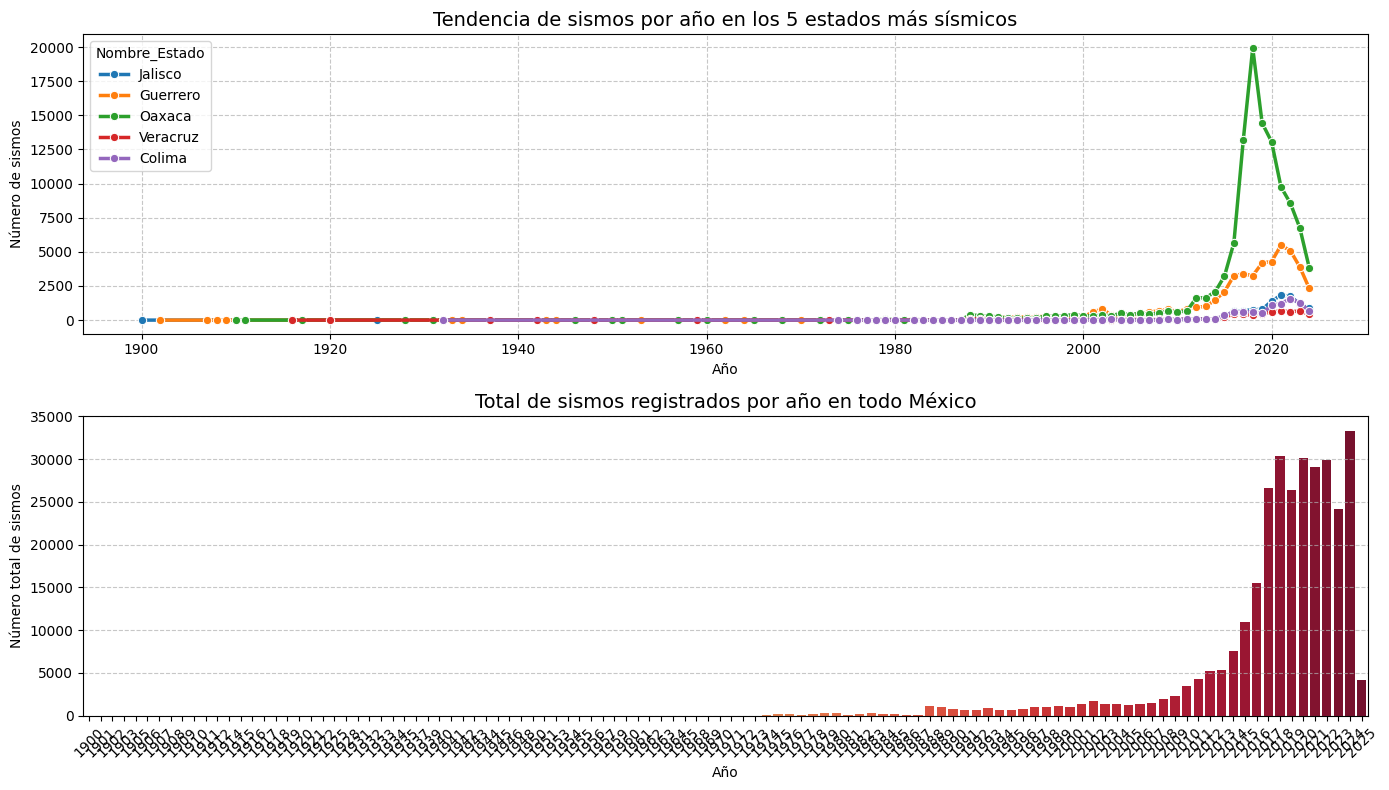

Análisis de tendencia nacional de sismos:
Coeficiente de correlación: 0.52
Tendencia (pendiente): 107.89 sismos/año
La frecuencia de sismos ha AUMENTADO en promedio a lo largo del período analizado.

Tendencias por estado:
Oaxaca: AUMENTANDO (66.70 sismos/año), r=0.48
Guerrero: AUMENTANDO (22.55 sismos/año), r=0.57
Jalisco: AUMENTANDO (7.40 sismos/año), r=0.47
Colima: AUMENTANDO (13.00 sismos/año), r=0.60
Veracruz: AUMENTANDO (4.37 sismos/año), r=0.57


In [126]:
# 7. Cambios en el Tiempo: Número de sismos por año en cada región

# Extraer el año de la fecha de los sismos
sismos['Año'] = pd.to_datetime(sismos['Fecha']).dt.year

# Extraer la región (estado) de la columna de referencia de localización
sismos['Estado'] = sismos['Referencia de localizacion'].str.extract(r',\s*([A-Z]{3})$')

# Asegurarse de que la columna Estado tenga nombres completos para mejor visualización
mapeo_estados = {
    'AGS': 'Aguascalientes', 'BC': 'Baja California', 'BCS': 'Baja California Sur',
    'CAMP': 'Campeche', 'CHIS': 'Chiapas', 'CHIH': 'Chihuahua', 'CDMX': 'Ciudad de México',
    'COAH': 'Coahuila', 'COL': 'Colima', 'DGO': 'Durango', 'GTO': 'Guanajuato',
    'GRO': 'Guerrero', 'HGO': 'Hidalgo', 'JAL': 'Jalisco', 'MEX': 'México',
    'MICH': 'Michoacán', 'MOR': 'Morelos', 'NAY': 'Nayarit', 'NL': 'Nuevo León',
    'OAX': 'Oaxaca', 'PUE': 'Puebla', 'QRO': 'Querétaro', 'QROO': 'Quintana Roo',
    'SLP': 'San Luis Potosí', 'SIN': 'Sinaloa', 'SON': 'Sonora', 'TAB': 'Tabasco',
    'TAMPS': 'Tamaulipas', 'TLAX': 'Tlaxcala', 'VER': 'Veracruz', 'YUC': 'Yucatán',
    'ZAC': 'Zacatecas'
}
sismos['Nombre_Estado'] = sismos['Estado'].map(mapeo_estados)

# Contar sismos por año y estado
sismos_por_anio_estado = sismos.groupby(['Año', 'Nombre_Estado']).size().reset_index(name='Cantidad_Sismos')

# Identificar los 5 estados con más sismos para el análisis
top_estados = sismos.groupby('Nombre_Estado').size().nlargest(5).index.tolist()

# Filtrar solo para los estados más sísmicos
sismos_top_estados = sismos_por_anio_estado[sismos_por_anio_estado['Nombre_Estado'].isin(top_estados)]

# Visualización de tendencias temporales
plt.figure(figsize=(14, 8))

# Gráfico de líneas para los 5 estados con más sismos
plt.subplot(211)
sns.lineplot(
    data=sismos_top_estados,
    x='Año',
    y='Cantidad_Sismos',
    hue='Nombre_Estado',
    marker='o',
    linewidth=2.5
)
plt.title('Tendencia de sismos por año en los 5 estados más sísmicos', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número de sismos')
plt.grid(True, linestyle='--', alpha=0.7)

# Gráfico de barras para el total nacional por año
plt.subplot(212)
sismos_total_anual = sismos.groupby('Año').size().reset_index(name='Total_Sismos')
sns.barplot(
    data=sismos_total_anual,
    x='Año',
    y='Total_Sismos',
    palette='YlOrRd'
)
plt.title('Total de sismos registrados por año en todo México', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número total de sismos')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Análisis de tendencia
from scipy import stats

# Calcular tendencia general (coeficiente de correlación y pendiente)
tendencia_nacional = stats.linregress(
    sismos_total_anual['Año'], 
    sismos_total_anual['Total_Sismos']
)

print(f"Análisis de tendencia nacional de sismos:")
print(f"Coeficiente de correlación: {tendencia_nacional.rvalue:.2f}")
print(f"Tendencia (pendiente): {tendencia_nacional.slope:.2f} sismos/año")
if tendencia_nacional.slope > 0:
    print(f"La frecuencia de sismos ha AUMENTADO en promedio a lo largo del período analizado.")
elif tendencia_nacional.slope < 0:
    print(f"La frecuencia de sismos ha DISMINUIDO en promedio a lo largo del período analizado.")
else:
    print(f"No hay una tendencia clara en la frecuencia de sismos a lo largo del tiempo.")

# Análisis de tendencia para los estados con más actividad sísmica
print("\nTendencias por estado:")
for estado in top_estados:
    datos_estado = sismos_por_anio_estado[sismos_por_anio_estado['Nombre_Estado'] == estado]
    if len(datos_estado) > 2:  # Verificar que hay suficientes datos para calcular tendencia
        tendencia = stats.linregress(datos_estado['Año'], datos_estado['Cantidad_Sismos'])
        direccion = "AUMENTANDO" if tendencia.slope > 0 else "DISMINUYENDO"
        print(f"{estado}: {direccion} ({tendencia.slope:.2f} sismos/año), r={tendencia.rvalue:.2f}")

Eficiencia economica en zonas de riego

C:\Users\Dell Latitude\AppData\Local\Temp\ipykernel_13880\418568578.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


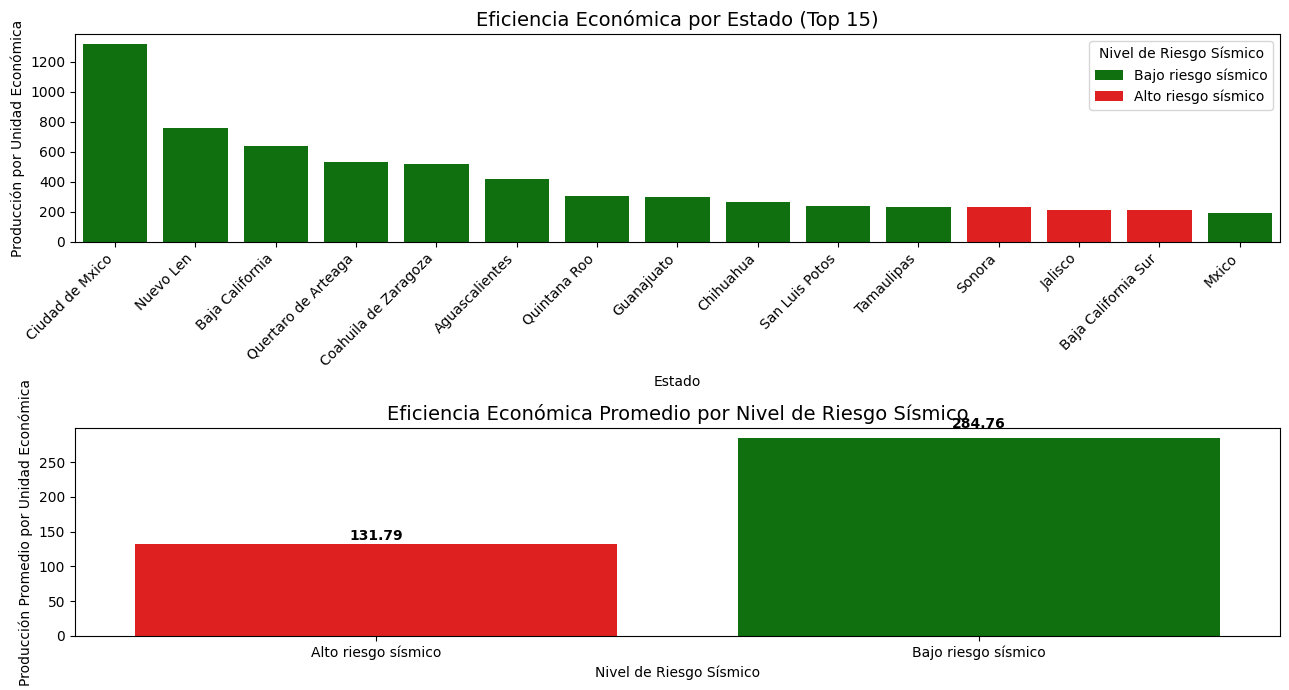

Eficiencia promedio en zonas de alto riesgo: 131.79
Eficiencia promedio en zonas de bajo riesgo: 284.76
Diferencia: -152.96
Estadístico t: -2.22
Valor p: 0.0345
Conclusión: Existe una diferencia estadísticamente significativa en la eficiencia económica entre zonas de alto y bajo riesgo sísmico.


In [132]:
# 8. Eficiencia Económica en Zonas de Riesgo:
# Producción ÷ Unidades económicas en zonas sísmicas

# Identificar estados con actividad sísmica significativa
# Contar sismos por estado y ordenar por cantidad
sismos_por_estado = sismos.groupby('Nombre_Estado').size().reset_index(name='Cantidad_Sismos')
sismos_por_estado = sismos_por_estado.sort_values(by='Cantidad_Sismos', ascending=False)

# Definir zonas de riesgo (top 10 estados con más sismos)
zonas_riesgo = sismos_por_estado.head(10)['Nombre_Estado'].tolist()

# Obtener datos económicos por estado
# Asumo que economia_municipios tiene las columnas necesarias
# Agrupar y sumar por estado
economia_agregada = economia_municipios.groupby('nombre_entidad').agg({
    'produccion_bruta_total': 'sum',
    'codigo': 'count'  # Usando 'codigo' como proxy para contar unidades económicas
}).reset_index()

# Renombrar columna para claridad
economia_agregada = economia_agregada.rename(columns={'codigo': 'unidades_economicas'})

# Calcular la eficiencia económica (producción por unidad económica)
economia_agregada['eficiencia_economica'] = economia_agregada['produccion_bruta_total'] / economia_agregada['unidades_economicas']

# Clasificar estados según su nivel de riesgo sísmico
economia_agregada['zona_riesgo'] = economia_agregada['nombre_entidad'].apply(
    lambda x: 'Alto riesgo sísmico' if x in zonas_riesgo else 'Bajo riesgo sísmico'
)

# Ordenar por eficiencia económica
economia_agregada = economia_agregada.sort_values(by='eficiencia_economica', ascending=False)

# Calcular promedio de eficiencia por tipo de zona
eficiencia_promedio = economia_agregada.groupby('zona_riesgo')['eficiencia_economica'].mean().reset_index()

# Visualización
plt.figure(figsize=(13,7))

# Gráfico 1: Eficiencia económica por estado, coloreado por zona de riesgo
plt.subplot(211)
sns.barplot(
    data=economia_agregada.head(15),  # Top 15 estados más eficientes
    x='nombre_entidad', 
    y='eficiencia_economica',
    hue='zona_riesgo',
    palette={'Alto riesgo sísmico': 'red', 'Bajo riesgo sísmico': 'green'}
)
plt.title('Eficiencia Económica por Estado (Top 15)', fontsize=14)
plt.xlabel('Estado')
plt.ylabel('Producción por Unidad Económica')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nivel de Riesgo Sísmico')

# Gráfico 2: Comparativa de eficiencia entre zonas de riesgo y no riesgo
plt.subplot(212)
sns.barplot(
    data=eficiencia_promedio,
    x='zona_riesgo',
    y='eficiencia_economica',
    palette={'Alto riesgo sísmico': 'red', 'Bajo riesgo sísmico': 'green'}
)
plt.title('Eficiencia Económica Promedio por Nivel de Riesgo Sísmico', fontsize=14)
plt.xlabel('Nivel de Riesgo Sísmico')
plt.ylabel('Producción Promedio por Unidad Económica')

# Agregar etiquetas de valor
for i, row in enumerate(eficiencia_promedio.itertuples()):
    plt.text(i, row.eficiencia_economica*1.05, 
             f'{row.eficiencia_economica:.2f}', 
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis estadístico
from scipy import stats

# Dividir los datos en dos grupos según zona de riesgo
alto_riesgo = economia_agregada[economia_agregada['zona_riesgo'] == 'Alto riesgo sísmico']['eficiencia_economica']
bajo_riesgo = economia_agregada[economia_agregada['zona_riesgo'] == 'Bajo riesgo sísmico']['eficiencia_economica']

# Realizar prueba t para comparar los dos grupos
t_stat, p_value = stats.ttest_ind(alto_riesgo, bajo_riesgo, equal_var=False)

print(f"Eficiencia promedio en zonas de alto riesgo: {alto_riesgo.mean():.2f}")
print(f"Eficiencia promedio en zonas de bajo riesgo: {bajo_riesgo.mean():.2f}")
print(f"Diferencia: {alto_riesgo.mean() - bajo_riesgo.mean():.2f}")
print(f"Estadístico t: {t_stat:.2f}")
print(f"Valor p: {p_value:.4f}")

if p_value < 0.05:
    print("Conclusión: Existe una diferencia estadísticamente significativa en la eficiencia económica entre zonas de alto y bajo riesgo sísmico.")
else:
    print("Conclusión: No hay evidencia estadística suficiente para afirmar que la eficiencia económica difiere entre zonas de alto y bajo riesgo sísmico.")

In [160]:
poblacion = poblacion_utf8.copy()

In [161]:

poblacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108327 entries, 0 to 108326
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ENTIDAD   108327 non-null  int64  
 1   NOM_ENT   108327 non-null  object 
 2   MUN       108327 non-null  int64  
 3   NOM_MUN   108327 non-null  object 
 4   LOC       108327 non-null  int64  
 5   NOM_LOC   108327 non-null  object 
 6   LONGITUD  108327 non-null  float64
 7   LATITUD   108327 non-null  float64
 8   POBTOT    108327 non-null  int64  
 9   POBFEM    108327 non-null  object 
 10  POBMAS    108327 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.1+ MB


In [162]:
# 9. Análisis Geoespacial: Visualización de Sismos y Variables Económicas en Mapa
import folium
from folium.plugins import MarkerCluster, HeatMap
import pandas as pd
import numpy as np

# Centrar el mapa en México
mexico_lat, mexico_lon = 23.6345, -102.5528
mapa = folium.Map(location=[mexico_lat, mexico_lon], zoom_start=5, 
                  tiles='CartoDB positron', control_scale=True)

# Filtrar sismos significativos para los marcadores (magnitud > 7.5)
sismos_significativos = sismos[sismos['Magnitud'] > 6].copy()
sismos_significativos['Magnitud'] = pd.to_numeric(sismos_significativos['Magnitud'], errors='coerce')

# Preparar datos de economía por estado
estados_economia = economia_estados.copy()
estados_economia['id'] = estados_economia.index

# Preparar datos de población para visualización
grandes_poblaciones = poblacion[poblacion['POBTOT'] > 50000].copy()

# MODIFICACIÓN: Filtrar sismos para el mapa de calor (solo sismos de magnitud > 6.0)
# Esto se enfoca en sismos relevantes sin eliminar completamente el mapa de calor
sismos_para_calor = sismos[sismos['Magnitud'] > 5.0][['Latitud', 'Longitud', 'Magnitud']].dropna()
sismos_para_calor['Latitud'] = pd.to_numeric(sismos_para_calor['Latitud'], errors='coerce')
sismos_para_calor['Longitud'] = pd.to_numeric(sismos_para_calor['Longitud'], errors='coerce')
sismos_para_calor['Magnitud'] = pd.to_numeric(sismos_para_calor['Magnitud'], errors='coerce')

# Crear datos para la capa de calor
heat_data = [[row['Latitud'], row['Longitud'], row['Magnitud']-5] # Reducir el peso para que sea menos dominante
             for idx, row in sismos_para_calor.iterrows() 
             if not np.isnan(row['Latitud']) and not np.isnan(row['Longitud'])]

# MODIFICACIÓN: Ajustar los parámetros del mapa de calor
HeatMap(heat_data, 
        radius=8,    # Radio más reducido
        blur=12,     # Desenfoque para suavizar
        max_zoom=12,
        min_opacity=0.4,  # Opacidad mínima
        gradient={'0.5': 'blue', '0.7': 'lime', '0.8': 'yellow', '0.9': 'orange', '1.0': 'red'}, 
        name='Zonas de Actividad Sísmica', 
        show=True).add_to(mapa)  # Visible por defecto

# Añadir sismos significativos como marcadores agrupados
marker_cluster = MarkerCluster(name='Sismos Significativos (>7.5)', show=True).add_to(mapa)

for idx, row in sismos_significativos.iterrows():
    try:
        lat = float(row['Latitud'])
        lon = float(row['Longitud'])
        mag = float(row['Magnitud'])
        
        # Determinar color según magnitud
        if mag >= 7.5:
            color = 'darkred'
        elif mag >= 7.0:
            color = 'red'
        elif mag >= 6.5:
            color = 'orange'
        else:
            color = 'lightred'
            
        # Crear marcador con información del sismo
        folium.CircleMarker(
            location=[lat, lon],
            radius=mag * 1.5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(
                f"<b>Fecha:</b> {row['Fecha']}<br>"
                f"<b>Magnitud:</b> {mag}<br>"
                f"<b>Profundidad:</b> {row['Profundidad']} km<br>"
                f"<b>Ubicación:</b> {row['Referencia de localizacion']}<br>",
                max_width=200
            )
        ).add_to(marker_cluster)
    except (ValueError, TypeError):
        continue

# Añadir grandes ciudades como marcadores
ciudades_group = folium.FeatureGroup(name='Ciudades Principales', show=True).add_to(mapa)
for idx, row in grandes_poblaciones.iterrows():
    try:
        lat = float(row['LATITUD'])
        lon = float(row['LONGITUD'])
        poblacion = int(row['POBTOT'])
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=np.log(poblacion/10000) * 2,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5,
            popup=f"<b>{row['NOM_LOC']}, {row['NOM_ENT']}</b><br>Población: {poblacion:,}"
        ).add_to(ciudades_group)
    except (ValueError, TypeError):
        continue

# Añadir controles de capas
folium.LayerControl().add_to(mapa)

# Añadir título al mapa
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 300px; height: 30px; 
            background-color: rgba(255, 255, 255, 0.8);
            border-radius: 5px; z-index: 9999; font-family: Arial;
            text-align: center; padding: 5px;">
    <b>Sismos, Economía y Población en México</b>
</div>
'''
mapa.get_root().html.add_child(folium.Element(title_html))

# Añadir leyenda
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px;
            background-color: rgba(255, 255, 255, 0.8);
            border-radius: 5px; z-index: 9999; font-family: Arial;
            padding: 10px;">
    <p style="margin: 0; font-weight: bold;">Magnitud de Sismos</p>
    <p style="margin: 0;"><i class="fa fa-circle" style="color:darkred;"></i> ≥ 7.5</p>
    <p style="margin: 0;"><i class="fa fa-circle" style="color:red;"></i> 7.0 - 7.4</p>
    <p style="margin: 0;"><i class="fa fa-circle" style="color:orange;"></i> 6.5 - 6.9</p>
    <p style="margin: 0;"><i class="fa fa-circle" style="color:lightred;"></i> 6.0 - 6.4</p>
    <p style="margin: 5px 0 0 0; font-weight: bold;">Ciudades</p>
    <p style="margin: 0;"><i class="fa fa-circle" style="color:blue;"></i> Principales poblaciones</p>
</div>
'''
mapa.get_root().html.add_child(folium.Element(legend_html))

# Mostrar el mapa
mapa